# Exercise 1.1 - Train a Nationality Classifier

# Getting started in NLP

In this first exercise, you'll begin your NLP journey by training a text classifier and exploring what kinds of options affect its performance. Text classification problems are everywhere NLP and here, we'll be looking at Wikipedia articles, which feature a lot of very interesting meta-data we can use to reasonable its text. Specifically, in the first exercise, we'll be looking at biographies of people and trying to predict their nationality, as reported in Wikipedia. Nationalities make for an interesting class to predict since biographies often contain many descriptions of places, events, organizations (e.g., universities), that all help ground a person in a geographic area. However, people are often international and move about&mdash;perhaps some of you have also moved about too&mdash;so the task is not trivial!

As a part of this first notebook, we'll build a simple classifier, `LogisticRegression` using the [sklearn](https://scikit-learn.org/stable/index.html) package. This package is often the initial toolbox for NLP practitioners to build and prototype models. Many of its classes provide useful built-in functionality for doing NLP preprocessing steps like tokenization, counting bigrams, or calculating TF-IDF values. These steps simplify much of what you need to build to create a "minimum viable product" in your first classifier (for any task!) and get a sense of how challenging the task is. We opt to start with Logistic Regression because it is not only quite quick to train, but performs competitively in many settings. However,  many `sklearn` classes for prediction have the same interface, so the skills you learn here will let you easily test out other classifiers and use them in practice.

In one part of this notebook, you'll explore how much data you need. Wikipedia is big enough that we have lots of examples of many nationalities. This surplus of data can let us try estimating the effect of the amount of data on our eventual performance. 

Finally, as an NLP _practitioner_ you'll have many tools at your disposal. This notebook is just a start for options you could explore. We've listed a few ways you could try exploring on your own to learn more about text classification. Sometimes the best way to see how something works is to try it out yourself. If you finish all the notebooks and want to go even further and see what current NLP is up to, the field often hosts what are known as _shared tasks_ through the [SemEval](https://semeval.github.io/) workshop series, where anyone can try solving a current research problem on training data researchers have released (sort of like a research Kaggle). If you want to try your hand, feel try to try developing a method for a SemEval task&mdash;some of which might still be going on!

In [1]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

It's good practice to manually set your random seed when performing machine learning experiments so that they are reproducible for others. Here, we set our seed to 655 to ensure your models and experiments get the expected results when evaluating your homework.

In [2]:
RANDOM_SEED = 655

# Data Processing

Read in the corpus file, which is in JSON lines format (one line per JSON object). Each line represents cleaned up data of a single Wikipedia article for a person. For this exercise, we'll construct a list of tuples where the first element is the aggregated `bio` of the person's article (their biography) and the second element is their nationality. The birth year is specified as a string in the `nationality` field of the `infobox` of the page. If someone doesn't have a nationality in their infobox, you should skip their article.

*Important Note:* Wikipedians sometimes have inconsistent spelling and capitalization for nationalities. To add some minimal text normalization you should _lower case_ the nationality. In general, it's always a good idea to look at how noisy your text is before deciding on its final form.

In [3]:
nationality_df = pd.read_csv('assets/nationality.tsv.gz', sep='\t', compression='gzip')
nationality_df = nationality_df.dropna()

In [4]:
nationality_df.head()

,Unnamed: 0,bio,nationality
0,0,Alain Connes (born 1 April 1947) is a French m...,french
1,1,Life\n=== Early life ===\nSchopenhauer's birth...,german
2,2,Life and career\nAlfred Nobel at a young age i...,swedish
3,3,"Early life\nAlfred Vogt (both ""Elton"" and ""van...",canadian
4,4,Alfons Maria Jakob (2 July 1884 in Aschaffenbu...,german


Let's check that you have things loaded correctly

### Task 1.1.1: Print the dataset size

In [5]:
print(len(nationality_df)) # Should be 319358
#hidden tests are within this cell

319358


### Task 1.1.2: Print the number of nationality labels

In [6]:
print(len(set(nationality_df.nationality))) # Should be 13616
#hidden tests are within this cell

13616


### Task 1.1.3: Print out the top 100 most common nationalities to see what Wikipedia's labels look like
You might have noticed that's a huge number of nationalities! What might be going on in the data? Let's use python's `Counter` object to print out the 100 most common nationalities in our dataset

In [7]:
top_100 = Counter(nationality_df.nationality).most_common(100)
#hidden tests are within this cell
top_100

[('american', 43157),
 ('british', 16635),
 ('indian', 10761),
 ('united states, american', 9811),
 ('australian', 8285),
 ('french', 7365),
 ('german', 6628),
 ('italian', 5403),
 ('japanese', 5223),
 ('canadian', 5083),
 ('united states', 4915),
 ('americans, american', 3804),
 ('english', 3507),
 ('mexican', 3294),
 ('canadians, canadian', 3280),
 ('pakistani', 3114),
 ('spanish', 3090),
 ('usa', 2973),
 ('russian', 2910),
 ('united kingdom, british', 2894),
 ('norwegian', 2851),
 ('polish', 2790),
 ('chinese', 2456),
 ('irish', 2218),
 ('swedish', 2189),
 ('dutch', 2103),
 ('brazilian', 1936),
 ('austrian', 1812),
 ('south korean', 1762),
 ('nigerian', 1705),
 ('swiss', 1643),
 ('british people, british', 1621),
 ('bangladeshi', 1613),
 ('hungarian', 1599),
 ('belgian', 1597),
 ('germany, german', 1544),
 ('serbian', 1521),
 ('danish', 1454),
 ('turkish', 1433),
 ('south african', 1430),
 ('irish people, irish', 1418),
 ('romanian', 1389),
 ('france, french', 1376),
 ('argentine', 

### Life Pro Tip: Always look at your data (always)
As you might have noticed, there's a bit of noise in Wikipedia's labels! Sometimes nationality is reported as "british" and sometimes "united kingdom, british". This kind of weirdness is very common in real datasets. As a practitioner in NLP, you need to be on guard at all times against any kind of weirdness that might distort your results. A good habit to get into (starting with this lesson!) is to look at your data and see if you spot anything unusual. Sometimes (like in this lesson), you can easily clean up errors or inconsistencies.

### Task 1.1.4: Fix the nationality labels
We won't fix _everything_ but as a quick fix that should improve our data's nationality labels, you should use python's `split()` function to divide these labels when they have a comma and take the last word, which we'll treat as the official national label. *Important note:* Remember that `split` matches exactly what you put in, but there might be variable whitespace around the final token. Use `strip()` to ensure that no nationality has leading or trailing white space.

In [8]:
nationality_df['nationality'] = nationality_df['nationality'].apply(lambda x: x.split(',')[-1].strip())

### Task 1.1.5: Double check the number of nationalities
We've ideally cut down on the number of easy-to-fix nationality name issues, so let's check by printing the number of unique nationalities now.

In [9]:
print(len(set(nationality_df.nationality))) # Should be 7865
#hidden tests are within this cell

7865


7,865 is still a big number, but we at least dropped a few thousand likely-bogus ones. For now, we'll move forward in the lesson, but recognize that when dealing with Real Data™ your work will likely involve lots of effort cleaning and sanitizing this data. I've intentionally started you out doing this practice to emphasize the need for double-checking and hopefully instill a healthy bit of skepticism (paranoia?) about data issues.

### Task 1.1.6: Print out the new list of 100 most common nationalities using Counter

In [10]:
top_100 = Counter(nationality_df.nationality).most_common(100)
#hidden tests are within this cell
top_100

[('american', 59647),
 ('british', 22284),
 ('indian', 12834),
 ('french', 9809),
 ('german', 8868),
 ('canadian', 8854),
 ('australian', 8688),
 ('italian', 7391),
 ('japanese', 6217),
 ('united states', 5063),
 ('english', 4833),
 ('spanish', 4249),
 ('irish', 4035),
 ('mexican', 3886),
 ('polish', 3709),
 ('russian', 3667),
 ('norwegian', 3505),
 ('dutch', 3446),
 ('pakistani', 3374),
 ('usa', 3021),
 ('chinese', 2912),
 ('swedish', 2738),
 ('brazilian', 2409),
 ('filipino', 2295),
 ('hungarian', 2162),
 ('swiss', 2080),
 ('austrian', 2003),
 ('turkish', 1927),
 ('scottish', 1921),
 ('belgian', 1894),
 ('danish', 1878),
 ('nigerian', 1836),
 ('south korean', 1809),
 ('serbian', 1739),
 ('bangladeshi', 1632),
 ('argentine', 1624),
 ('south african', 1538),
 ('greek', 1536),
 ('romanian', 1522),
 ('czech', 1520),
 ('iranian', 1468),
 ('finnish', 1458),
 ('eng', 1278),
 ('croatian', 1143),
 ('portuguese', 1127),
 ('sri lankan', 1118),
 ('ukrainian', 1117),
 ('ghanaian', 1114),
 ('egypt

### Task 1.1.7: Filter dataset to only those nationalities with at least 500 occurrences
When training any classifier, you need enough examples to learn features that reliably predict the labels. For this homework, let's restrict ourselves to working with only nationalities that have at least 500 occurrences. Create a set called `final_nationalities` that contains only those with at least 500 occurrences. Then, from this restricted label set, let's take the subset of `nationality_df` that use these and make a new list called `cleaned_nationality_df` that holds our final dataset that we'll use for train, test, and development.

*Side note:* Often, removing rare labels is another good way of getting rid of noise in our dataset. However, in practice, it's important to check these labels to make sure there are no (or few) systematic errors that would bias your model. Sometimes these biases can have significant real-world impact (e.g., underrepresenting people) and as an ethical data scientist, it's your job to combat the introduction of them.

In [11]:
final_nationalities = set()
for item, count in Counter(nationality_df.nationality).items():
    if count >=500:
        final_nationalities.add(item)
cleaned_nationality_df = nationality_df[nationality_df['nationality'].isin(final_nationalities)]

### Task 1.1.8: Print the number of nationalities with at least 500 occurrences

In [12]:
print(len(final_nationalities))
#hidden tests are within this cell

81


Much smaller!

### Task 1.1.9: Print the number of items in `cleaned_nationality_df`

In [13]:
print(len(cleaned_nationality_df))
#hidden tests are within this cell

260146


### Task 1.1.10: Split dataset into test, train and dev
We have a large enough dataset that we can effectively split it into train, development, and test sets, using the standard ratio of 80%, 10%, 10% for each, respectively. We'll use `split` from `numpy` to split the data into train, dev, and test separately. We'll call these `train_df`, `dev_df`, and `test_df`.  Note that `split` does not shuffle, so we'll use `DataFrame.sample()` and randomly resample our entire dataset to get a random shuffle before the split.

*Important note*: Remember to set  `random_state` in `DataFrame.sample()` to our seed so that you end up with the same (random) ordering

In [14]:
cleaned_nationality_df = cleaned_nationality_df.sample(frac=1,random_state=RANDOM_SEED)
train_df, dev_df, test_df = np.split(cleaned_nationality_df, [int(0.8 * len(cleaned_nationality_df)), \
                                                              int(0.9 * len(cleaned_nationality_df))])

### Task 1.1.11: print the `bio` of the  first instance of your training set

In [15]:
print(train_df.iloc[0,:]['bio'])
#hidden tests are within this cell

Giulio Benedetto Isacco Vivanti (24 May 1859 – 19 November 1949) was an Italian mathematician. He spent most of his academic career at the University of Pavia and University of Milan.


### Task 1.1.12: Print the first instance of the test set

In [16]:
print(test_df.iloc[0,:]['bio'])
#hidden tests are within this cell

Early life
Schaffelhuber was born in Regensburg, Bavaria, Germany. She was born with an incomplete spinal cord and as a result has paraplegia and uses a wheelchair. She began monoskiing at age five and at age fourteen received a scholarship to join a national junior skiing programme.
Career
Schaffelhuber competes in the LW10 para-alpine skiing classification using a sitting mono-ski and outriggers.

She was selected for the German team at the 2010 Winter Paralympics held in Vancouver, British Columbia, Canada where she competed in four events. She won the bronze medal in the super-G finishing behind Claudia Lösch of Austria and American Alana Nichols in a time of 1 minute 38.25 seconds. She also finished fourth in two events, the super combined and the slalom, and seventh in the giant slalom. During the closing ceremony of the Games she carried the German flag.

She skied at the 2011 IPC Alpine Skiing World Championships, held in Sestriere, Italy. She won the three gold medals, in the 

## Final Sanity Checking / Data Exploration

### Task 1.1.13: Check out the token frequencies
We looked at the nationality labels, but what's all in the biographies? As a final sanity check, we'll take a look at this data to build a bit of intuition for steps that we'll take when training our classifier. As a first task, let's try tokenizing each biography and getting a count of all the unique words for biographies in `train_df` using `Counter`. The function Counter from collections creates a dict subclass for counting hashable objects. In this task we expect students to create 3 different “Counters”. For more details on Counter please visit the source: https://docs.python.org/3/library/collections.html


What tokens should count as a "word" and how do we find them? For this exercise, we'll try extract three kinds of tokens using different methods to see what happens

1. ws_tokens: dict count of tokens separated by whitespace
2. alpha_ws_tokens: dict count of tokens separated by whitespace and are alpha numeric 
3. alpha_re_tokens: dict count of tokens separated by word boundaries that only consist of alphanumeric characters


As quick example of how these are different, let's say we have the sentence "My computer says 'I don't know...' but after thinking about it, I think it does."

* The first case should return `['My', 'computer', 'says', "'I", "don't", "know...'", 'but', 'after', 'thinking', 'about', 'it,', 'I', 'think', 'it', 'does.']`, which we can see contains a bunch of tokens that have punctuation with them.

* The second case should return `['My', 'computer', 'says', 'but', 'after', 'thinking', 'about', 'I', 'think', 'it']` which is filtering out a _lot_ more tokens. We see that any token with any punctuation gets removed. This is probably too much but the tokens do look cleaner

* The third case should return `['My', 'computer', 'says', 'I', 'don', 't', 'know', 'but', 'after', 'thinking', 'about', 'it', 'I', 'think', 'it', 'does']`, which gives us all the tokens. Here we see that it's also split "don't" into two tokens too! We could modify our regex some to allow intra-token punctuation to avoid this but for now we'll keep it a it simple.

To build some intuition, mentally estimate how many unique tokens you think will be in each set before starting the exercise. Will the third set be 80% of the size? 50%? 

_Hint:_ the default string `.split()` function can help

_Hint:_ `re.fullmatch` and `re.match` do subtly different things but you only want to use one of them

_Hint:_ the `re.findall` method may be useful here for one type of token

_Hint:_ The tokens in case 2 are a subset of those in case 1. This means you can speed your token extraction a bit if you check smartly. 

_Hint:_ The reference implementation takes around 2 minutes and 40 seconds

advise using regex to fill the variables above. For information on regex visit the source: https://www.rexegg.com/regex-quickstart.html
Read and Explore the documentation: https://docs.python.org/3/library/re.htmlHighly 

In [17]:
# Fill this with any token (with anything in it!) for tokens separated by whitespace
ws_tokens = Counter()

# Fill this one with tokens separated by whitespace but constisting only of tokens
# that are totally made of alphanumeric characters (you can use the \w character
# class in making the regex)
alpha_ws_tokens = Counter()

# Fill this one with the tokens separated by *word boundaries* (not white space) that consist
# of alphanumeric characters (use \w again)
alpha_re_tokens = Counter()
# for bio in tqdm(train_df.bio):
#     #HINT: Iterate through all bios found in train_df:
#         #HINT: At the current bio, we may now split by whitespace to find words found at this instance. 
#             #HINT: At the current word, given that word(s) are split base on whitespace, update our ws_tokens counter
            
#             #HINT: If the current word is also alphanumeric: update our alpha_ws_tokens
# 		#HINT: Otherwise, we will ignore
#         	#HINT: We may use built in regex functions to fill alpha_re_tokens by passing in the current bio
             
#     # YOUR CODE HERE
#     tokens = re.findall(r'\b\w+\b', bio.lower())
#     ws_tokens.update(tokens)
#     # tokenize words separated by whitespace that are alphanumeric
#     alpha_tokens = [t for t in tokens if t.isalnum()]
#     alpha_ws_tokens.update(alpha_tokens)
#     # tokenize words separated by word boundaries that are alphanumeric
#     re_tokens = re.findall(r'\w+', bio.lower())
#     alpha_re_tokens.update(re_tokens)
# #     raise NotImplementedError()
for bio in tqdm(train_df.bio):
    tokens = bio.split()
    ws_tokens.update(tokens)
    alpha_tokens = [t for t in tokens if re.fullmatch(r'\w+', t)]
    alpha_ws_tokens.update(alpha_tokens)
    re_tokens = re.findall(r'\w+', bio)
    alpha_re_tokens.update(re_tokens)

100%|██████████| 208116/208116 [01:18<00:00, 2653.88it/s]


### Task 1.1.14: Print the sizes of each dictionary in order on separate line
Note that the hidden tests here will check the sizes of the counters to make sure you've constructed your regexes correctly.

In [18]:
print(len(ws_tokens))
print(len(alpha_ws_tokens))
print(len(alpha_re_tokens))
#hidden tests are within this cell

1767930
472407
665404


Surprising! Why do you think there is such a difference in size?

### Task 1.1.15: Let's look at the most common 50 words in the third definition (alphanumeric tokens in a word boundary). Print them out

In [19]:
top_50 = alpha_re_tokens.most_common(50)
#hidden tests are within this cell
top_50

[('the', 2973148),
 ('in', 1789058),
 ('of', 1760646),
 ('and', 1644560),
 ('a', 1143221),
 ('to', 1038387),
 ('was', 904405),
 ('his', 534102),
 ('he', 529518),
 ('for', 502094),
 ('at', 493490),
 ('as', 441176),
 ('s', 425784),
 ('He', 420936),
 ('on', 419628),
 ('with', 390131),
 ('In', 330904),
 ('from', 289517),
 ('by', 277543),
 ('The', 258366),
 ('that', 221529),
 ('an', 220896),
 ('is', 216600),
 ('her', 213653),
 ('she', 173478),
 ('had', 155072),
 ('University', 147555),
 ('first', 144841),
 ('She', 143001),
 ('also', 140674),
 ('which', 136687),
 ('born', 131127),
 ('life', 110854),
 ('career', 110395),
 ('1', 102510),
 ('has', 101714),
 ('who', 98504),
 ('were', 95306),
 ('where', 93489),
 ('years', 92592),
 ('after', 88568),
 ('became', 88148),
 ('time', 85397),
 ('New', 84985),
 ('one', 84702),
 ('two', 81925),
 ('2', 80381),
 ('but', 79524),
 ('His', 79015),
 ('On', 75850)]

### Task 1.1.16: Plot the word distribution
We certainly have a lot of unique words in our data! In many corpora, word frequencies follow [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), which is a power-law like distribution. In essence, a few words are _very_ common and account for most of the tokens we have in the data (this is where the word-type/token distinction is important!), while many words are relatively rare and infrequently occur in our data. 

First, let's create two lists `x` and `y`, where `x` holds the word's rank when sorted by frequency (e.g., the most common word is `0`, the fifth most-common is `4`, etc.) and `y` holds the probability of the word at rank _i_. 

In [20]:
x= []
y= []

for elem, occurance in alpha_re_tokens.most_common():
    x.append(elem)
    y.append(occurance)

To see Zipf's law in action, let's plot the _probability_ of seeing a word on a log-scale y-axis and order our words by the most probable first and also log-scale the x-axis. Uncomment the lines below to plot this.

_Hint:_ you can log-scale an axis in pyplot using `plt.yscale('log')` 

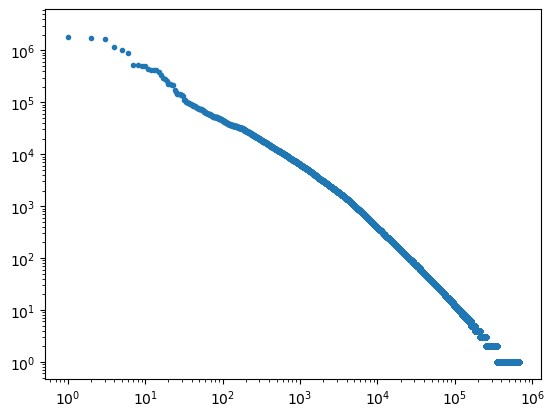

In [21]:
ax = plt.plot(x, y, '.')
plt.yscale('log')
plt.xscale('log')

Wow, would you look at that!

# Training and testing your classifiers

### Task 1.1.17: Convert your text data to features
The dataset has been prepared and the time has now arrived to actually start doing some predictions! We'll be using a `TfIdfVectorizer` to convert the text into features. There are several important things to note:

1. We have a *lot* of words. There are almost too many to feasibly use unless we're running on a powerful computer. _But_ as we saw above, most words are actually relatively rare. This rarity is quite useful for us because it means we can remove these words as features to our classifier and they shouldn't affect performance too much (after all, the classifier can't learn from features that are rarely present).
2. In addition to rare words, there are generally a few very common words that appear in most comments. These are often known as _stop words_ like "the". In most settings (but not all!), these features don't add much information so we can safely remove them to be more efficient.

The [TfIdfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class thankfully provides easy ways for us to do both. We'll use `min_df` to ensure that word show up at least 500 times and use `stop_words` to specify their default `english` list. 

Create this `TfIdfVectorizer` and call it vectorizer. Then, call `fit_transform` on the list of biographies in  `train_df` to convert the text into a matrix of features we'll call `X_train`. `X` is the standard name you'll see for feature matrices in machine learning, and usually it has a suffix in code to indicate which data it came from, e.g., `X_test`.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=500, stop_words='english')
X_train = vectorizer.fit_transform(train_df['bio'])

### Task 1.1.18: Sanity Check: print the shape of X_train
Let's ensure that we featurized everything as expected. You should have 6,009 word features in your training data.

In [23]:
print(X_train.shape)
#hidden tests are within this cell

(208116, 6009)


### Task 1.1.19: Get the list of labels
We need to get the final list of labels in a python `list` for sklearn to use. Create this list from `train_df` and let's call it `y_train`. `y` (lower case!) is normally used to refer to the label of the classifier (or value in  a regressor) in machine learning. We use the lower case here to indicate it's a vector, whereas `X` is upper case because it's a matrix.

In [24]:
y_train = list(train_df.nationality)

### Task 1.1.20: Fit the classifier on a subset of the data
Finally, let's fit the classifier. For a start we'll use `LogisticRegression`. Don't forget to set the `random_state` to use our `RANDOM_SEED` so you get deterministic (but random) results. To train your classifier, create a `LogisticRegression` object (typically classifiers are named `clf`) and call `fit` passing in `X_train` and `y_train`.

For this cell, let's just use the first 10,000 rows of `X_train` and `y_train` to fit the classifier. In general, when you have a large dataset, it's useful to go end-to-end and train one of these half-baked classifiers to verify that your model works as expected. You can even do some analyses if the performance is good enough to get a sense of how things are working. Then you can train on the full data.

*Notes:*
1. You should make sure to use the `lbfgs` solver, as this generally Just Works™ and is fast.
2. Since we have more than two nationalities, we'll set `multi_class='auto'` so that the classifier isn't binary.
3. `X_train` is a numpy array, so you'll need to use array indexing operations to get the first 10,000 rows.

In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=RANDOM_SEED)
clf.fit(X_train[:10000], y_train[:10000])

LogisticRegression(random_state=655)

### Task 1.1.21: Generate dev data
Let's generate the numpy matrices for the development data. Take the text in our `dev_df` and pass it through the vectorizer to turn it into features. We'll call this `X_dev`. Also create a list of the corresponding labels for each item, which we'll call `y_dev`

In [26]:
X_dev = vectorizer.transform(dev_df.bio)
y_dev = list(dev_df.nationality)

### Task 1.1.22: Create Dummy classifiers
It's always important to contextualize your results by comparing it with naive classifiers. If these classifiers do well, then your task is easy! If not, then you can see how much better your system does at first. We'll use two different strategies using the [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) class. Create two `DummyClassifier` instances that use the `uniform` (guess randomly) and `most_frequent` strategies and fit these on the training data so we can compare them with our regressor that was trained on 10K instances. In general, you probably always want to at least compare with these two baselines in a classification task.

*NOTE:* Be sure to set the `random_state` of the `DummyClassifier` to be `RANDOM_SEED` so your scores match.

In [27]:
from sklearn.dummy import DummyClassifier

# uniform (random) guessing
dummy_uniform = DummyClassifier(strategy='uniform', random_state=RANDOM_SEED)
dummy_uniform.fit(X_train[:10000], y_train[:10000])

# always predict most frequent class
dummy_most_frequent = DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED)
dummy_most_frequent.fit(X_train[:10000], y_train[:10000])

DummyClassifier(random_state=655, strategy='most_frequent')

### Task 1.1.23: Generate all the predictions
Let's generate our predictions. We have three models: our `LogisticRegression` model trained on 10K items and two `DummyClassifier` models that are baselines. Using our `X_dev` data, predict the nationality for each person and store these as:
* `lr_tiny_dev_preds`
* `rand_dev_preds`
* `mf_dev_preds`

In [28]:
# Predict on the development data
lr_tiny_dev_preds = clf.predict(X_dev)
rand_dev_preds = dummy_uniform.predict(X_dev)
mf_dev_preds = dummy_most_frequent.predict(X_dev)

### Task 1.1.24: Score our predictions
Now, let's score the models. Here, we'll use F1 to score and use a _macro_ average so that the score reflects the average F1 performance across all classes. Many NLP problems have more than two labels and we care about our performance on each. The macro-averaged F1 is especially important in these multiclass settings where some labels are less common, since it will tell us how well we're doing overall. 

Score your three models on the dev set using macro-averaged F1 and save these scores as `lr_f1`, `rand_f1`, and `mf_f1`.

In [29]:
lr_f1 = f1_score(y_dev, lr_tiny_dev_preds, average='macro')
rand_f1 = f1_score(y_dev, rand_dev_preds, average='macro')
mf_f1 = f1_score(y_dev, mf_dev_preds, average='macro')

In [30]:
print(lr_f1)
print(rand_f1)
print(mf_f1)
#hidden tests are within this cell

0.5398376431883924
0.009222142509427461
0.004651872187905132


Wow, pretty good even for training on just 10K items! But still lots of room for improvement.

### Task 1.1.25: Fit the classifier on the full data
Let's see if we can improve our performance with more data. Train a new `LogisticRegression` model on the full dataset.

In [31]:
clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=RANDOM_SEED)
clf.fit(X_train, y_train)

LogisticRegression(random_state=655)

### Task 1.1.26: Generate all the predictions for the model and score it
Save your predictions as `lr_dev_preds` and the model's performance as `lr_f1`

In [32]:
# import pickle
# pickle.dump(clf, open("assign_1_1", 'wb'))

In [33]:
# clf = pickle.load(open("assign_1_1", 'rb'))

In [34]:
lr_dev_preds = clf.predict(X_dev)
lr_f1 = f1_score(y_dev, lr_dev_preds, average='macro')

In [35]:
print(lr_f1)
#hidden tests are within this cell

0.7681561055388213


Why might this performance be so high? Hint: Think about some of the most common words you might see

# How much data do we need?
With performance so high, how much data do we need to get an accurate classifier? For NLP, it's often useful to see how the performance changes relative to how many training examples you have. For some tasks with heavily structured text, you might only need a few hundred examples to get good performance&mdash;but for others with highly variable text, you might need tens of thousands to learn generalizable features across all of the data. 

In this part of the exercise, we'll re-use parts of our code to generate performance numbers for random samples of the full dataset.

Using part of your code above, finishing the function below that receives two data frames to use as training and evaluation. The function should fit a new `TfidfVectorizer` and train a LogisticRegression classifier from the training data and then evaluate on the provided dev data. The function returns the macro-averaged F1 score on the dev data.

In [36]:
def train_and_score(train_df, dev_df):
    vectorizer = TfidfVectorizer(min_df=500, stop_words='english')
    X_train = vectorizer.fit_transform(train_df['bio'])
    y_train = list(train_df.nationality)
    X_dev = vectorizer.transform(dev_df.bio)
    y_dev = list(dev_df.nationality)
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_dev)
    f1 = f1_score(y_dev, y_pred, average='macro')
    return f1

### Evaluate on different subsets of the data to see how performance increases with dataset size
Using our `train_and_score` function, we'll test how the same classification model changes in performance as we add more data. In the code below, write a function called `change_in_performance`. You will use your output to answer the prompts in the Exercise 1.1 Quiz in Coursera.

**Before you submit your assignment to the autograde, be sure to comment out the function call.**

_NOTE 1:_ If this method is slow at first, try using a smaller sample of `dev_items` when initially debugging and then use the full `dev_items` after

_NOTE 2:_ For speed, we're only recording one performance number here. However if you expect to see a lot of variability in your models, it's worth evaluating multiple models for each training set size and reporting bootstrapped F1 scores.

In [37]:
def change_in_performance(training_sizes, train_df, dev_df):
    random.seed(RANDOM_SEED)
    f1_scores = []
    for training_size in tqdm(training_sizes):
        f1 = train_and_score(train_df.sample(n=training_size, random_state=RANDOM_SEED), dev_df)
        f1_scores.append(f1)
    return(f1_scores)

training_sizes = [1000, 10000, 50000, 100000]
performace_f1_scores = change_in_performance(training_sizes, train_df, dev_df)

100%|██████████| 4/4 [06:25<00:00, 96.34s/it]


### Plot the performances for each training data set size
We'll use seaborn's barplot to show performance

**Be sure to comment out the code below before you submit to the autograder.**

[0.004651872187905132, 0.09516666352189217, 0.4353537047016176, 0.6425213726047228]


<AxesSubplot: xlabel='num_instances', ylabel='f1'>

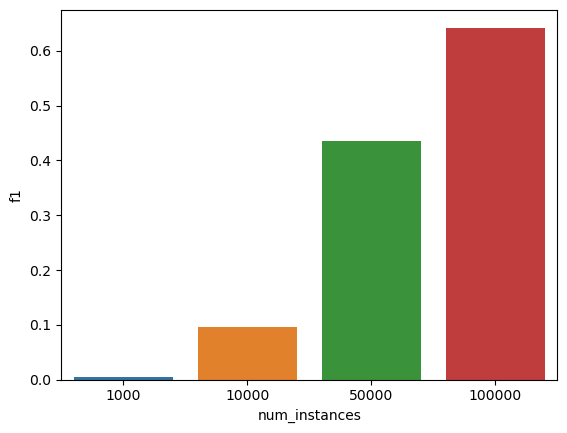

In [38]:
print(performace_f1_scores)

df = pd.DataFrame({'num_instances': training_sizes, 'f1': performace_f1_scores})
sns.barplot(data=df, x='num_instances', y='f1')

Overall lots of room for improvement. We could certainly try fine-tuning some of the hyperparameters though! Some useful ideas to try by altering the TF-IDF vectorizer or classifier:
* use lower `min_df` to increase the number of features
* don't use stopword removal
* tune the `C` parameter on the logistic regression classifier
* don't lower-case the text 
* use a `CountVectorizer` instead of a TF-IDF vectorizer
* set `max_df` to remove common features

Which do you think will lead to higher performance? Try some out and report on the Slack or Piazza what's the highest performance you can achieve!

## Using sequences as features

### Task 1.1.27: Fit a unigram and bigram LogisticRegression classifier
Unigrams and Bigrams can be powerful features  for classification. Let's see if our model gets better performance if we train a new model that now includes bigrams.

Create a new `TfidfVectorizer` with the same hyperparameter values but include a specification for `ngram_range` to use both unigrams and bigrams. Then call `fit_transform` on the training data to create a new feature matrix `X_train` with these features.

In [39]:
bigram_vectorizer = TfidfVectorizer(stop_words='english', min_df=500, ngram_range=(1,2))
X_train = bigram_vectorizer.fit_transform(train_df.bio)

### Task 1.1.28: Print the feature matrix shape when using unigrams and bigrams
Before you run this, it's useful to think about how many features you had before with unigrams. How many new bigrams do you expect?

In [40]:
X_train.shape

(208116, 7473)

### Task 1.1.29: Train the unigram and bigram classifier
Create a new `LogisticRegression` classifier model and fit it on the `X_train` and `y_train` data. Note that we don't have to recreate `y_train` since we are only changing how we featurize the text (not the labels  associated with the text).

In [41]:
clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=RANDOM_SEED)
clf.fit(X_train, y_train)

LogisticRegression(random_state=655)

### Featurize the development data
Use your new unigram+bigram featurizer to featurize the dev data and call this `X_dev`

In [42]:
X_dev = bigram_vectorizer.transform(dev_df.bio)
y_dev = list(dev_df.nationality)

### Use the new model to generate dev predictions and score them
Using your newly-trained model, generate predictions from it and score them using macro-average F1. Save the output in a variable called `lr_f1`.

In [43]:
y_pred = clf.predict(X_dev)
lr_f1 = f1_score(y_dev, y_pred, average='macro')

In [44]:
# print(lr_f1)

In [45]:
print(lr_f1)

0.7654679281164334
